In [58]:
import anndata
import lamindb as ln
import lnschema_bionty as lb
import numpy as np
import pandas as pd
import plotnine as p
import scanpy as sc
import scvi
from scvi.hub import HubMetadata, HubModel, HubModelCardHelper
from scvi.model.utils import mde

ln.settings.verbosity = "hint"

In [4]:
collection = ln.Collection.filter(reference = '10.6084/m9.figshare.24670038.v1').first()

In [5]:
collection.artifact.describe()

Artifact(uid='Ozi5e56JPczsASuiogM1', suffix='.h5ad', accessor='AnnData', description='mmColon_single_cell_85K.mouse.h5ad', size=1417611876, hash='0DmeGGGnh8d5kyurRHNBVK', hash_type='sha1-fl', visibility=1, key_is_virtual=True, updated_at=2024-02-11 03:19:56 UTC)

Provenance:
  🗃️ storage: Storage(uid='3wVRAheC', root='s3://vals-scrna', type='s3', region='us-west-1', updated_at=2023-11-05 20:36:19 UTC, created_by_id=1)
  📔 transform: Transform(uid='PBAb0NkPEmLe5zKv', name='Ingest into Lamin', short_name='240210 ingest data', version='1', type='notebook', updated_at=2024-02-11 01:42:41 UTC, created_by_id=1)
  👣 run: Run(uid='KZkeImCbTr4cdraU3THw', run_at=2024-02-11 02:26:43 UTC, transform_id=2, created_by_id=1)
  👤 created_by: User(uid='8joZB4lw', handle='vals', updated_at=2023-11-05 20:36:19 UTC)
Labels:
  🏷️ organism (1, bionty.Organism): 'mouse'
  🏷️ tissues (1, bionty.Tissue): 'colon'
  🏷️ experimental_factors (1, bionty.ExperimentalFactor): 'Chromium'



In [6]:
adata = collection.artifact.load()

💡 you can auto-track these data as a run input by calling `ln.track()`


In [7]:
adata

AnnData object with n_obs × n_vars = 84612 × 18416
    obs: 'sid', 'n_genes', 'condition', 'batch', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'CCI', 'CCI_sample', 'Celltype_marker_DB', 'DEG', 'DEG_stat', 'GSA_down', 'GSA_up'
    obsm: 'HiCAT_result'

In [17]:
adata.obs['total_counts'] = np.array(adata.X.sum(1))[:, 0]

In [18]:
scvi.model.SCVI.setup_anndata(
    adata,
    size_factor_key = 'total_counts',
)

model = scvi.model.SCVI(
    adata,
    gene_likelihood = 'nb'
)

2024-02-10 22:32:04,163:INFO - Unable to initialize backend 'cuda': 
2024-02-10 22:32:04,164:INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-02-10 22:32:04,171:INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-02-10 22:32:04,173:WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [19]:
1e6 / adata.shape[0]

11.818654564364392

In [20]:
model.train(max_epochs = 50)

INFO: GPU available: True (cuda), used: True
2024-02-10 22:33:48,214:INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-02-10 22:33:48,216:INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-02-10 22:33:48,218:INFO - IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-02-10 22:33:48,219:INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-02-10 22:33:50,292:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [08:28<00:00, 10.14s/it, v_num=1, train_loss_step=5.83e+3, train_loss_epoch=5.66e+3]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
2024-02-10 22:42:19,100:INFO - `Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [08:28<00:00, 10.18s/it, v_num=1, train_loss_step=5.83e+3, train_loss_epoch=5.66e+3]


2024-02-10 22:43:07,148:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


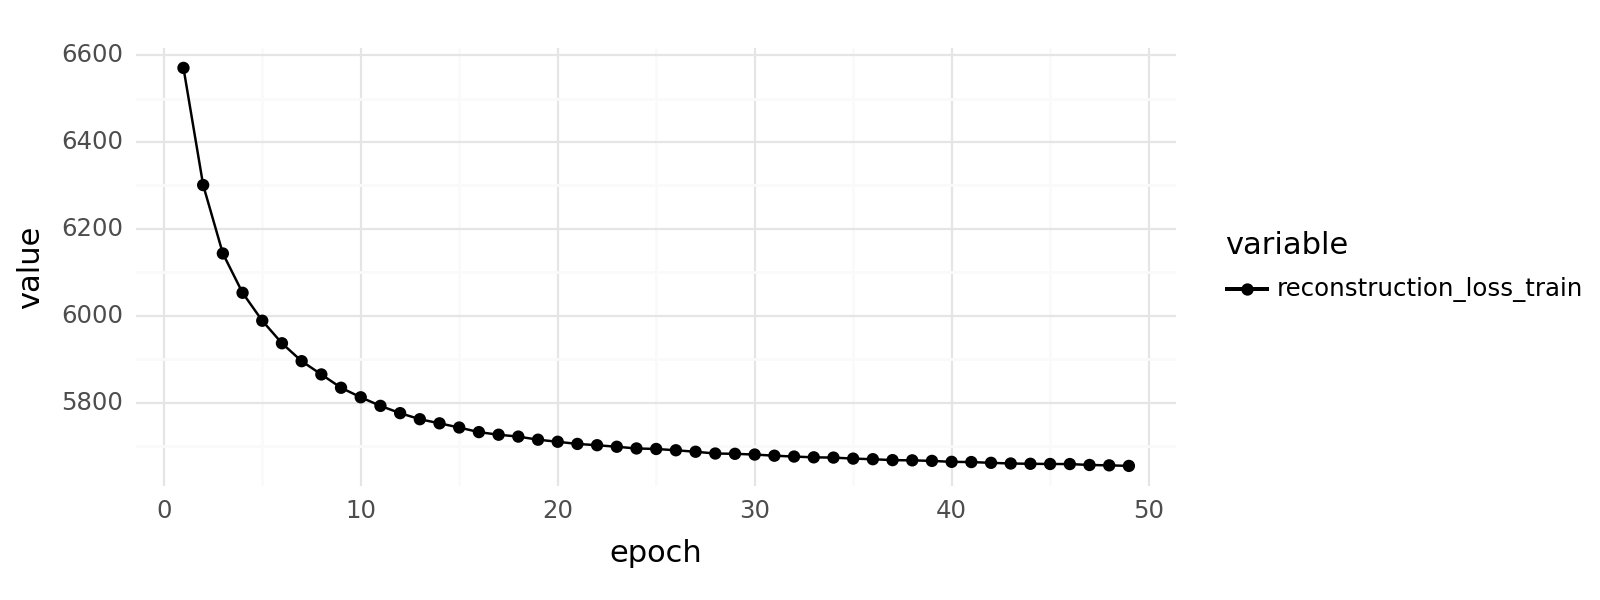

In [23]:
history_df = (
    model.history['reconstruction_loss_train'].astype(float)
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 8, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'reconstruction_loss_train': 'black', 'reconstruction_loss_validation': 'red'})
    + p.theme_minimal()
)

# p_.save('fig1.png', dpi = 300)

print(p_)

In [24]:
qzm, qzv = model.get_latent_representation(give_mean = False, return_dist = True)
model.adata.obsm['X_latent_qzm'] = qzm
model.adata.obsm['X_latent_qzv'] = qzv

In [25]:
model.adata.obsm['X_mde'] = scvi.model.utils.mde(model.adata.obsm['X_latent_qzm'])

In [29]:
for i, y in enumerate(adata.obsm['X_mde'].T):
    adata.obs[f'mde_{i + 1}'] = y

In [30]:
model.adata

AnnData object with n_obs × n_vars = 84612 × 18416
    obs: 'sid', 'n_genes', 'condition', 'batch', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset', 'total_counts', '_scvi_batch', '_scvi_labels', 'mde_1', 'mde_2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'CCI', 'CCI_sample', 'Celltype_marker_DB', 'DEG', 'DEG_stat', 'GSA_down', 'GSA_up', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'HiCAT_result', 'X_latent_qzm', 'X_latent_qzv', 'X_mde'

2024-02-10 22:52:06,103:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


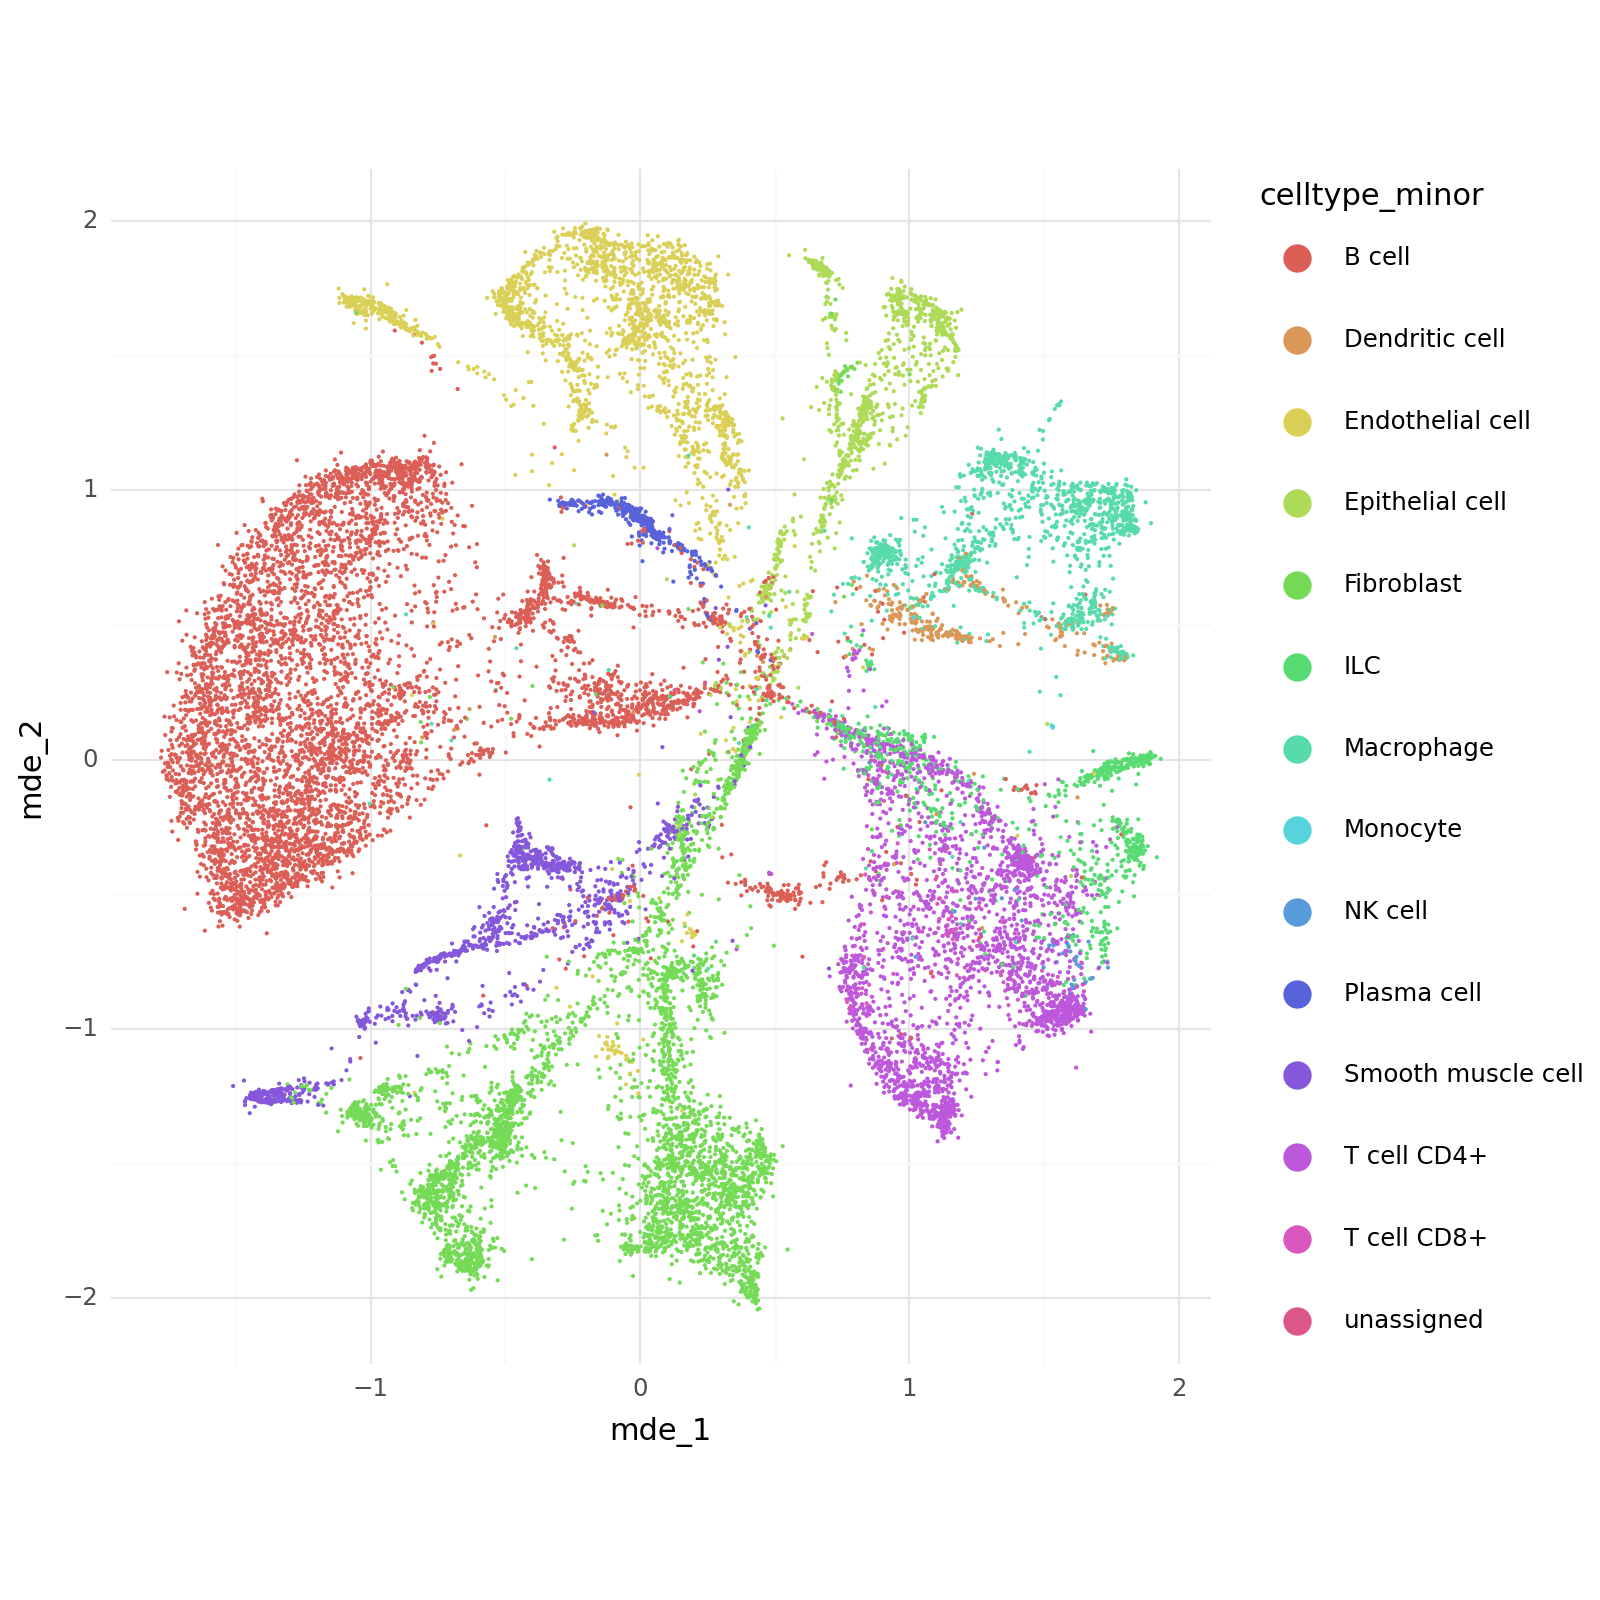

In [36]:
p.options.figure_size = 8, 8

tmp_ = model.adata.obs.sample(20_000)

p_ = (
    p.ggplot(p.aes(x = 'mde_1', y = 'mde_2', color = 'celltype_minor'), tmp_)
    # + p.geom_point(shape = '.', size = 0.1, color = 'lightgrey', data = tmp_.drop(['participant_ids'], axis = 1))
    + p.geom_point(shape = '.', size = 0.2)
    + p.coord_equal()
    + p.theme_minimal()
    + p.guides(color = p.guide_legend(override_aes = {'size': 10}))
    # + p.facet_grid('participant_ids ~ .', labeller = 'label_both')
)

# p_.save('fig3.png', dpi = 300)

print(p_)

2024-02-10 22:52:21,080:INFO - Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


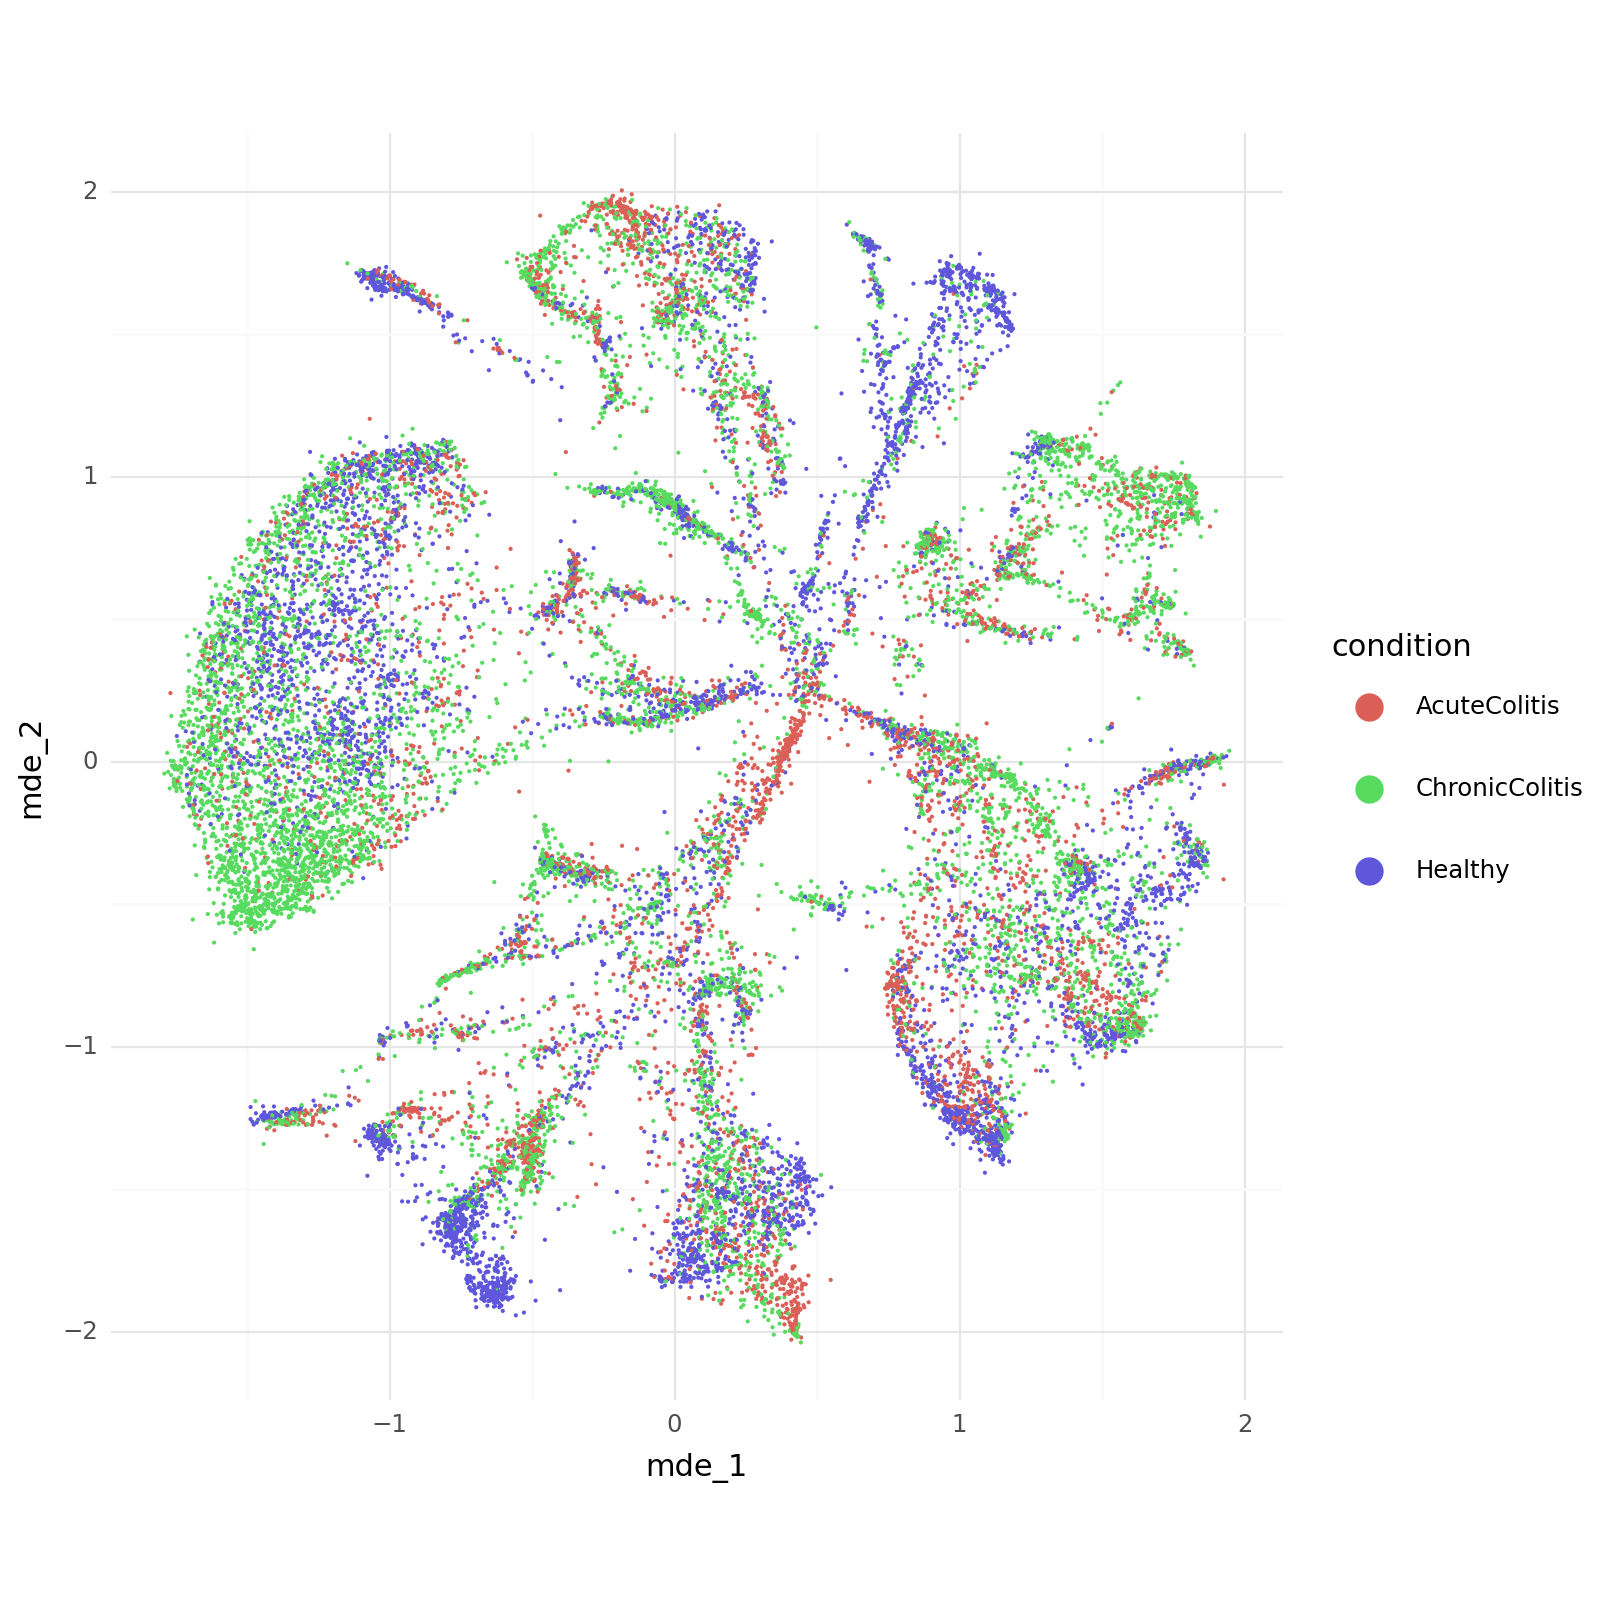

In [37]:
p.options.figure_size = 8, 8

tmp_ = model.adata.obs.sample(20_000)

p_ = (
    p.ggplot(p.aes(x = 'mde_1', y = 'mde_2', color = 'condition'), tmp_)
    # + p.geom_point(shape = '.', size = 0.1, color = 'lightgrey', data = tmp_.drop(['participant_ids'], axis = 1))
    + p.geom_point(shape = '.', size = 0.2)
    + p.coord_equal()
    + p.theme_minimal()
    + p.guides(color = p.guide_legend(override_aes = {'size': 10}))
    # + p.facet_grid('participant_ids ~ .', labeller = 'label_both')
)

# p_.save('fig3.png', dpi = 300)

print(p_)

In [39]:
collection.artifact.describe()

Artifact(uid='Ozi5e56JPczsASuiogM1', suffix='.h5ad', accessor='AnnData', description='mmColon_single_cell_85K.mouse.h5ad', size=1417611876, hash='0DmeGGGnh8d5kyurRHNBVK', hash_type='sha1-fl', visibility=1, key_is_virtual=True, updated_at=2024-02-11 03:19:56 UTC)

Provenance:
  🗃️ storage: Storage(uid='3wVRAheC', root='s3://vals-scrna', type='s3', region='us-west-1', updated_at=2023-11-05 20:36:19 UTC, created_by_id=1)
  📔 transform: Transform(uid='PBAb0NkPEmLe5zKv', name='Ingest into Lamin', short_name='240210 ingest data', version='1', type='notebook', updated_at=2024-02-11 01:42:41 UTC, created_by_id=1)
  👣 run: Run(uid='KZkeImCbTr4cdraU3THw', run_at=2024-02-11 02:26:43 UTC, transform_id=2, created_by_id=1)
  👤 created_by: User(uid='8joZB4lw', handle='vals', updated_at=2023-11-05 20:36:19 UTC)
Labels:
  🏷️ organism (1, bionty.Organism): 'mouse'
  🏷️ tissues (1, bionty.Tissue): 'colon'
  🏷️ experimental_factors (1, bionty.ExperimentalFactor): 'Chromium'



In [43]:
sc.tl.rank_genes_groups(adata, 'condition', )

In [44]:
adata

AnnData object with n_obs × n_vars = 84612 × 18416
    obs: 'sid', 'n_genes', 'condition', 'batch', 'sample', 'celltype_major', 'celltype_minor', 'celltype_subset', 'total_counts', '_scvi_batch', '_scvi_labels', 'mde_1', 'mde_2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'CCI', 'CCI_sample', 'Celltype_marker_DB', 'DEG', 'DEG_stat', 'GSA_down', 'GSA_up', '_scvi_uuid', '_scvi_manager_uuid', 'rank_genes_groups'
    obsm: 'HiCAT_result', 'X_latent_qzm', 'X_latent_qzv', 'X_mde'

In [45]:
adata.uns['rank_genes_groups']

{'params': {'groupby': 'condition',
  'reference': 'rest',
  'method': 't-test',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('Gm15564', 'Cd74', 'Rps27rt'),
            ('Lars2', 'Cd86', 'ENSMUSG00000105361'),
            ('ENSMUSG00000098178', 'H2-Aa', 'Rps27'), ...,
            ('Rpl27', 'ND2', 'Gm15564'), ('Rpl13', 'Gsn', 'Slfn2'),
            ('Rps7', 'ND3', 'Bcl2l11')],
           dtype=[('AcuteColitis', 'O'), ('ChronicColitis', 'O'), ('Healthy', 'O')]),
 'scores': rec.array([( 45.53404 ,  46.53903 ,  60.592136),
            ( 40.304775,  41.389324,  51.234554),
            ( 39.657883,  41.13179 ,  51.08344 ), ...,
            (-51.378212, -46.474724, -42.967262),
            (-51.414837, -51.20475 , -42.98376 ),
            (-55.67896 , -58.45085 , -45.95929 )],
           dtype=[('AcuteColitis', '<f4'), ('ChronicColitis', '<f4'), ('Healthy', '<f4')]),
 'pvals': rec.array([(0., 0., 0.), (0., 0., 0.), (0., 0., 0.), ..., (0., 0

In [50]:
adata.uns['rank_genes_groups']['names']

rec.array([('Gm15564', 'Cd74', 'Rps27rt'),
           ('Lars2', 'Cd86', 'ENSMUSG00000105361'),
           ('ENSMUSG00000098178', 'H2-Aa', 'Rps27'), ...,
           ('Rpl27', 'ND2', 'Gm15564'), ('Rpl13', 'Gsn', 'Slfn2'),
           ('Rps7', 'ND3', 'Bcl2l11')],
          dtype=[('AcuteColitis', 'O'), ('ChronicColitis', 'O'), ('Healthy', 'O')])

In [51]:
model.minify_adata()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [52]:
collection.artifact.description

'mmColon_single_cell_85K.mouse.h5ad'

In [56]:
mname = collection.artifact.description.replace('.h5ad', '.scvi.model')

In [57]:
model.save(mname, save_anndata = True, overwrite = True)

In [59]:
hm = HubMetadata.from_dir(mname, anndata_version = anndata.__version__)

INFO     File mmColon_single_cell_85K.mouse.scvi.model/model.pt already downloaded                                 


In [64]:
hm

HubMetadata(scvi_version='1.0.4', anndata_version='0.9.1', model_cls_name='SCVI', training_data_url=None, model_parent_module='scvi.model')

In [66]:
hmch = HubModelCardHelper.from_dir(
    mname,
    license_info = "cc-by-4.0",
    anndata_version = anndata.__version__,
    data_modalities = ["rna"],
    data_is_annotated = True,
    description = collection.artifact.description,
    references = collection.reference
)

INFO     File mmColon_single_cell_85K.mouse.scvi.model/model.pt already downloaded                                 


In [69]:
hmo = HubModel(mname, metadata = hm, model_card = hmch)
hmo

HubModel with:
local_dir: mmColon_single_cell_85K.mouse.scvi.model
model loaded? No
adata loaded? No
large_training_adata loaded? No
metadata:
HubMetadata(scvi_version='1.0.4', anndata_version='0.9.1', model_cls_name='SCVI', training_data_url=None, model_parent_module='scvi.model')
model_card:


───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
license: cc-by-4.0                                                                                                 

library_name: scvi-tools                                                                                           

tags:                                                                                                              

 • biology                                                                                                         
 • genomics                                                                                                        
 • single-cell                                                                                                     
 • model_cls_name:SCVI                                                                                             
 • scvi_version:1.0.4                                                                                              
 • anndata_version:0.9.1                                                                                           
 • modality:rna                                                                                                    
 • annotated:True                                                                                                  

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                   Description                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

mmColon_single_cell_85K.mouse.h5ad                                                                                 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                Model properties                                                 ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

Many model properties are in the model tags. Some more are listed below.                                           

model_init_params:                                                                                                 

                                                                                                                   
                                                                                                                   
 {                                                                                                                 
                                                                                                                   
     "n_hidden": 128,                                                                                              
                                                                                                                   
     "n_latent": 10,                                                                                               
                                                                                                                   
     "n_layers": 1,                                                                                                
                                                                                                                   
     "dropout_rate": 0.1,                                                                                          
                                                                                                                   
     "dispersion": "gene",                     

In [83]:
hf_token = '/mnt/c/Users/vale/HF_token.txt'
token = pd.read_csv(hf_token).columns[0]

In [85]:
hmo.push_to_huggingface_hub(repo_name = 'valsv/' + mname, repo_token = token, repo_create = False)

In [86]:
mname

'mmColon_single_cell_85K.mouse.scvi.model'